# Assignment 2 - Part C: Comprehensive Analysis
This notebook performs hyperparameter analysis and model comparison for MNIST dataset using logistic regression, softmax regression, and custom neural networks.

In [24]:
# =========================
# Imports & Setup
# =========================
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## Cell 2: Methods from Part A
- Logistic Regression (binary)
- Softmax Regression (multiclass)
- MNIST Data Loader

In [25]:
# Logistic Regression Model (Binary)
class LogisticRegressionModel:
    def __init__(self, input_dim):
        self.W = torch.zeros(input_dim, 1, requires_grad=True, device=device)
        self.b = torch.zeros(1, requires_grad=True, device=device)

    def forward(self, X):
        return torch.sigmoid(X @ self.W + self.b)

    def compute_loss(self, y_pred, y_true):
        return -(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred)).mean()

    def train(self, X, y, lr=0.01, epochs=100):
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            loss.backward()
            with torch.no_grad():
                self.W -= lr * self.W.grad
                self.b -= lr * self.b.grad
                self.W.grad.zero_()
                self.b.grad.zero_()

# Softmax Regression Model (Multiclass)
class SoftmaxRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

# Custom Feedforward Neural Network
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Cell 3: Methods from Part B
- Custom Neural Network
- Training and Evaluation functions

In [26]:
# Custom Feedforward Neural Network
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [30]:
# =========================
# Data Loading
# =========================
def load_mnist_data():
    import torchvision.datasets as datasets
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    X_train = train_dataset.data.float() / 255
    y_train = train_dataset.targets
    X_test = test_dataset.data.float() / 255
    y_test = test_dataset.targets


    X_train = X_train.view(-1, 28*28)
    X_test = X_test.view(-1, 28*28)

    return X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# Load & split
X_train, y_train, X_test, y_test = load_mnist_data()

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_X, val_X = torch.split(X_train, [train_size, val_size])
train_y, val_y = torch.split(y_train, [train_size, val_size])

def get_loader(X, y, batch_size=64):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_dataset = TensorDataset(train_X, train_y)
val_dataset   = TensorDataset(val_X, val_y)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)


# =========================
# Training Functions
# =========================
def train_model(model, train_loader, val_loader, lr, epochs=10):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loss_list = []
    val_loss_list = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        train_loss_list.append(total_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)
            val_loss_list.append(val_loss / len(val_loader.dataset))

    return train_loss_list, val_loss_list

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            all_preds.append(y_pred.argmax(dim=1).cpu())
            all_labels.append(y_batch.cpu())
    y_pred_all = torch.cat(all_preds)
    y_true_all = torch.cat(all_labels)
    cm = confusion_matrix(y_true_all, y_pred_all)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    accuracy = (y_pred_all == y_true_all).float().mean()
    return accuracy.item(), cm



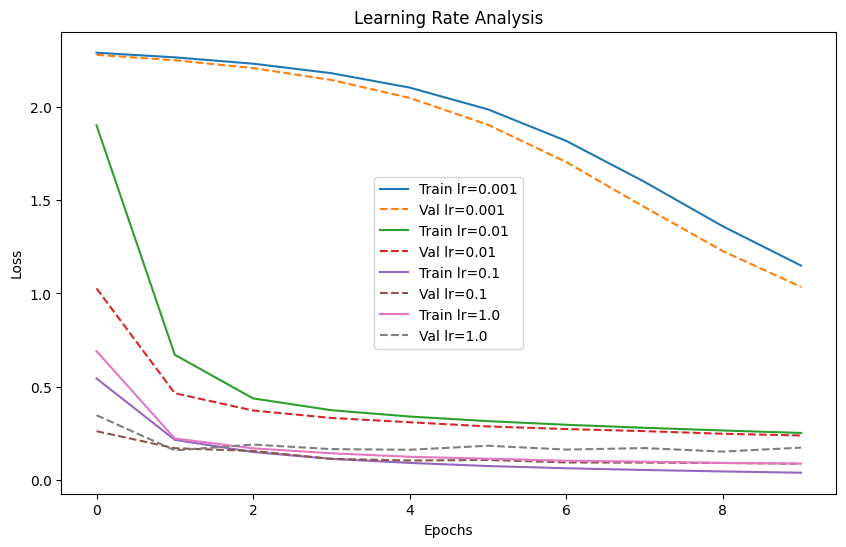

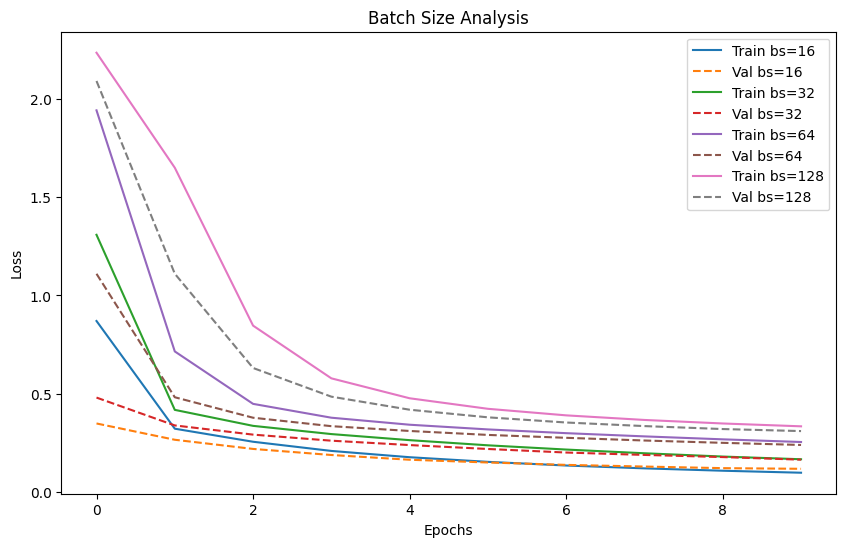

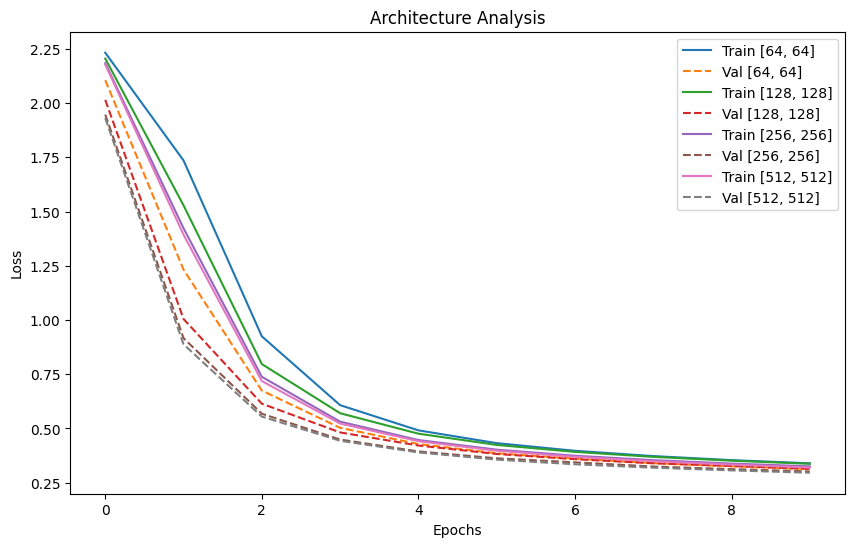

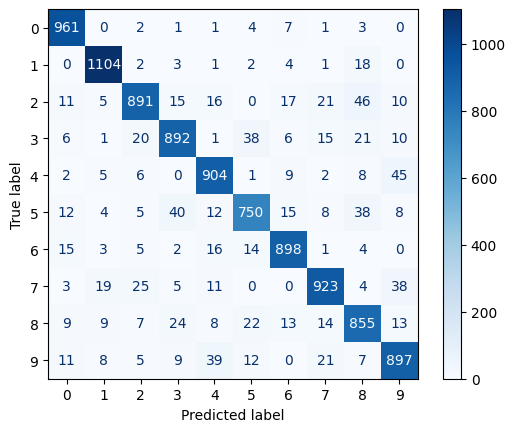

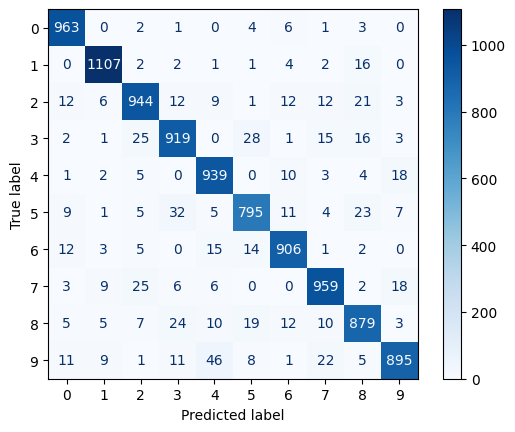

Performance Summary:
Logistic Regression (0 vs 1) Accuracy: N/A (binary only)
Softmax Regression Accuracy: 90.75%
MLP Neural Network Accuracy: 93.06%


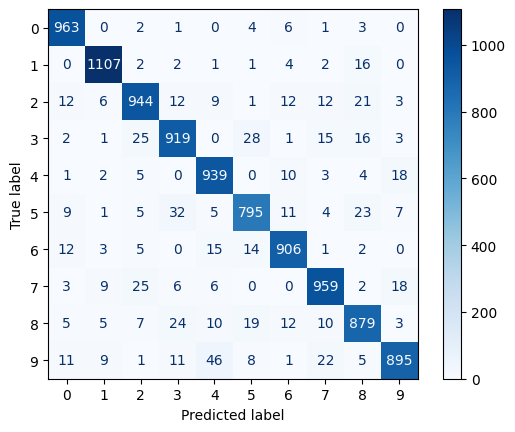

Best Model Test Accuracy: 93.06%


In [31]:
# =========================
# C1. Hyperparameter Analysis
# -------------------------
# Learning Rate
learning_rates = [0.001,0.01,0.1,1.0]
train_losses_dict, val_losses_dict = {}, {}
train_loader = get_loader(train_X, train_y, batch_size=64)
val_loader   = get_loader(val_X, val_y, batch_size=64)
for lr in learning_rates:
    mlp = CustomNeuralNetwork(28*28,[128,128],10).to(device)
    t_loss, v_loss = train_model(mlp, train_loader, val_loader, lr=lr, epochs=10)
    train_losses_dict[lr] = t_loss
    val_losses_dict[lr] = v_loss

plt.figure(figsize=(10,6))
for lr in learning_rates:
    plt.plot(train_losses_dict[lr], label=f"Train lr={lr}")
    plt.plot(val_losses_dict[lr],'--', label=f"Val lr={lr}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Rate Analysis")
plt.legend()
plt.show()

# -------------------------
# Batch Size Analysis
# -------------------------
batch_sizes = [16,32,64,128]
train_loss_bs, val_loss_bs = {}, {}
for bs in batch_sizes:
    train_loader = get_loader(train_X, train_y, batch_size=bs)
    val_loader   = get_loader(val_X, val_y, batch_size=bs)
    mlp = CustomNeuralNetwork(28*28,[128,128],10).to(device)
    t_loss, v_loss = train_model(mlp, train_loader, val_loader, lr=0.01, epochs=10)
    train_loss_bs[bs] = t_loss
    val_loss_bs[bs]   = v_loss

plt.figure(figsize=(10,6))
for bs in batch_sizes:
    plt.plot(train_loss_bs[bs], label=f"Train bs={bs}")
    plt.plot(val_loss_bs[bs],'--', label=f"Val bs={bs}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Batch Size Analysis")
plt.legend()
plt.show()

# -------------------------
# Architecture Analysis
# -------------------------
hidden_layer_configs = [
    [64,64],[128,128],[256,256],[512,512]
]
train_loss_arch, val_loss_arch = {}, {}
for config in hidden_layer_configs:
    mlp = CustomNeuralNetwork(28*28, config, 10).to(device)
    t_loss, v_loss = train_model(mlp, train_loader, val_loader, lr=0.01, epochs=10)
    train_loss_arch[str(config)] = t_loss
    val_loss_arch[str(config)]   = v_loss

plt.figure(figsize=(10,6))
for config in hidden_layer_configs:
    plt.plot(train_loss_arch[str(config)], label=f"Train {config}")
    plt.plot(val_loss_arch[str(config)], '--', label=f"Val {config}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Architecture Analysis")
plt.legend()
plt.show()

# =========================
# C2. Model Comparison
# -------------------------
# Prepare DataLoaders
train_loader = get_loader(train_X, train_y, batch_size=64)
val_loader   = get_loader(val_X, val_y, batch_size=64)
test_loader  = get_loader(X_test, y_test, batch_size=64)


# Logistic Regression (0 vs 1)
mask_train = (train_y==0)|(train_y==1)
mask_test  = (y_test==0)|(y_test==1)
log_model = LogisticRegressionModel(28*28)
log_model.train(train_X[mask_train], (train_y[mask_train]==1).float(), lr=0.01, epochs=10)

# Softmax and MLP
softmax_model = SoftmaxRegressionModel(28*28,10).to(device)
mlp_model     = CustomNeuralNetwork(28*28,[128,128],10).to(device)
train_model(softmax_model, train_loader, val_loader, lr=0.01, epochs=10)
train_model(mlp_model, train_loader, val_loader, lr=0.01, epochs=10)

# Evaluate
acc_softmax, cm_softmax = evaluate_model(softmax_model, test_loader)
acc_mlp, cm_mlp         = evaluate_model(mlp_model, test_loader)

print("Performance Summary:")
print(f"Logistic Regression (0 vs 1) Accuracy: N/A (binary only)")
print(f"Softmax Regression Accuracy: {acc_softmax*100:.2f}%")
print(f"MLP Neural Network Accuracy: {acc_mlp*100:.2f}%")

# =========================
# Best Model Evaluation (MLP)
# -------------------------
best_model = mlp_model
acc_best, cm_best = evaluate_model(best_model, test_loader)
print(f"Best Model Test Accuracy: {acc_best*100:.2f}%")